In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from sklearn.preprocessing import StandardScaler
from imblearn.ensemble import BalancedRandomForestClassifier

# Read the CSV and Perform Basic Data Cleaning

In [3]:
columns = [
    "loan_amnt", "int_rate", "installment", "home_ownership",
    "annual_inc", "verification_status", "issue_d", "loan_status",
    "pymnt_plan", "dti", "delinq_2yrs", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc",
    "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
    "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq",
    "tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il",
    "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
    "all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
    "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
    "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc",
    "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
    "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit", "hardship_flag", "debt_settlement_flag"
]

target = ["loan_status"]

In [4]:
# Load the data
file_path = Path('LoanStats_2019Q1.csv')
df = pd.read_csv(file_path, skiprows=1)[:-2]
df = df.loc[:, columns].copy()

# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()

# Remove the `Issued` loan status
issued_mask = df['loan_status'] != 'Issued'
df = df.loc[issued_mask]

# convert interest rate to numerical
df['int_rate'] = df['int_rate'].str.replace('%', '')
df['int_rate'] = df['int_rate'].astype('float') / 100


# Convert the target column values to low_risk and high_risk based on their values
x = {'Current': 'low_risk'}
df = df.replace(x)

x = dict.fromkeys(['Late (31-120 days)', 'Late (16-30 days)', 'Default', 'In Grace Period'], 'high_risk')
df = df.replace(x)

df.reset_index(inplace=True, drop=True)

df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


In [5]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df2 = df.copy()
df2['home_ownership'] = le.fit_transform(df2['home_ownership'])

df2['verification_status'] = le.fit_transform(df2['verification_status'])

df2['issue_d'] = le.fit_transform(df2['issue_d'])

df2['pymnt_plan'] = le.fit_transform(df2['pymnt_plan'])

df2['initial_list_status'] = le.fit_transform(df2['initial_list_status'])

df2['next_pymnt_d'] = le.fit_transform(df2['next_pymnt_d'])

df2['application_type'] = le.fit_transform(df2['application_type'])

df2['hardship_flag'] = le.fit_transform(df2['hardship_flag'])

df2['debt_settlement_flag'] = le.fit_transform(df2['debt_settlement_flag'])
df2.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,3,66000.0,1,2,low_risk,0,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,0,0
1,25000.0,0.2000,929.09,1,105000.0,2,2,low_risk,0,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,0,0
2,20000.0,0.2000,529.88,1,56000.0,2,2,low_risk,0,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,0,0
3,10000.0,0.1640,353.55,3,92000.0,2,2,low_risk,0,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,0,0
4,22000.0,0.1474,520.39,1,52000.0,0,2,low_risk,0,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,0,0


# Split the Data into Training and Testing

In [6]:
# Creating variable data set
X = df2.drop(columns='loan_status', axis=1)

# Creating output data set (Target)
y = df['loan_status']

# Check the balance of our target values
y.value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [7]:
from sklearn.model_selection import train_test_split
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Creating StandardScaler instance
scaler = StandardScaler()
# Fitting Standard Scaler
X_scaler = scaler.fit(X_train)
# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# BalancedRandomForestClassifier

In [8]:
# Instantiating 'BalancedRandomForestClassifier' model
balancedRF = BalancedRandomForestClassifier(n_estimators=100,random_state=1)

# Training the model
balancedRF = balancedRF.fit(X_train_scaled, y_train)

# Making prediction using the above model
predict = balancedRF.predict(X_test_scaled)
print(predict)

['low_risk' 'low_risk' 'low_risk' ... 'low_risk' 'low_risk' 'low_risk']


### Confusion Matrix

In [9]:
pd.DataFrame(confusion_matrix(y_test, predict),index=['Actually True', 'Actually False'], columns=['Predicted True', 'Predicted False'])

,Predicted True,Predicted False
Actually True,63,38
Actually False,2674,14430


### Balanced Accuracy Score

In [10]:
balanced_accuracy_score(y_test,predict)

0.7337123387268567

### Imbalanced Classification Report

In [11]:
print(classification_report_imbalanced(y_test,predict))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.02      0.62      0.84      0.04      0.73      0.51       101
   low_risk       1.00      0.84      0.62      0.91      0.73      0.54     17104

avg / total       0.99      0.84      0.63      0.91      0.73      0.54     17205



### Feature Importance Scores

In [12]:

importances = sorted(zip(balancedRF.feature_importances_, X.columns), reverse=True)
importances

df3 = pd.DataFrame(importances, columns=['Importance Score', 'Feature'])

In [13]:
df3

,Importance Score,Feature
0,0.076467,total_rec_prncp
1,0.068173,last_pymnt_amnt
2,0.056993,total_pymnt
3,0.054248,total_pymnt_inv
4,0.047350,total_rec_int
...,...,...
80,0.000000,delinq_amnt
81,0.000000,debt_settlement_flag
82,0.000000,collection_recovery_fee
83,0.000000,chargeoff_within_12_mths


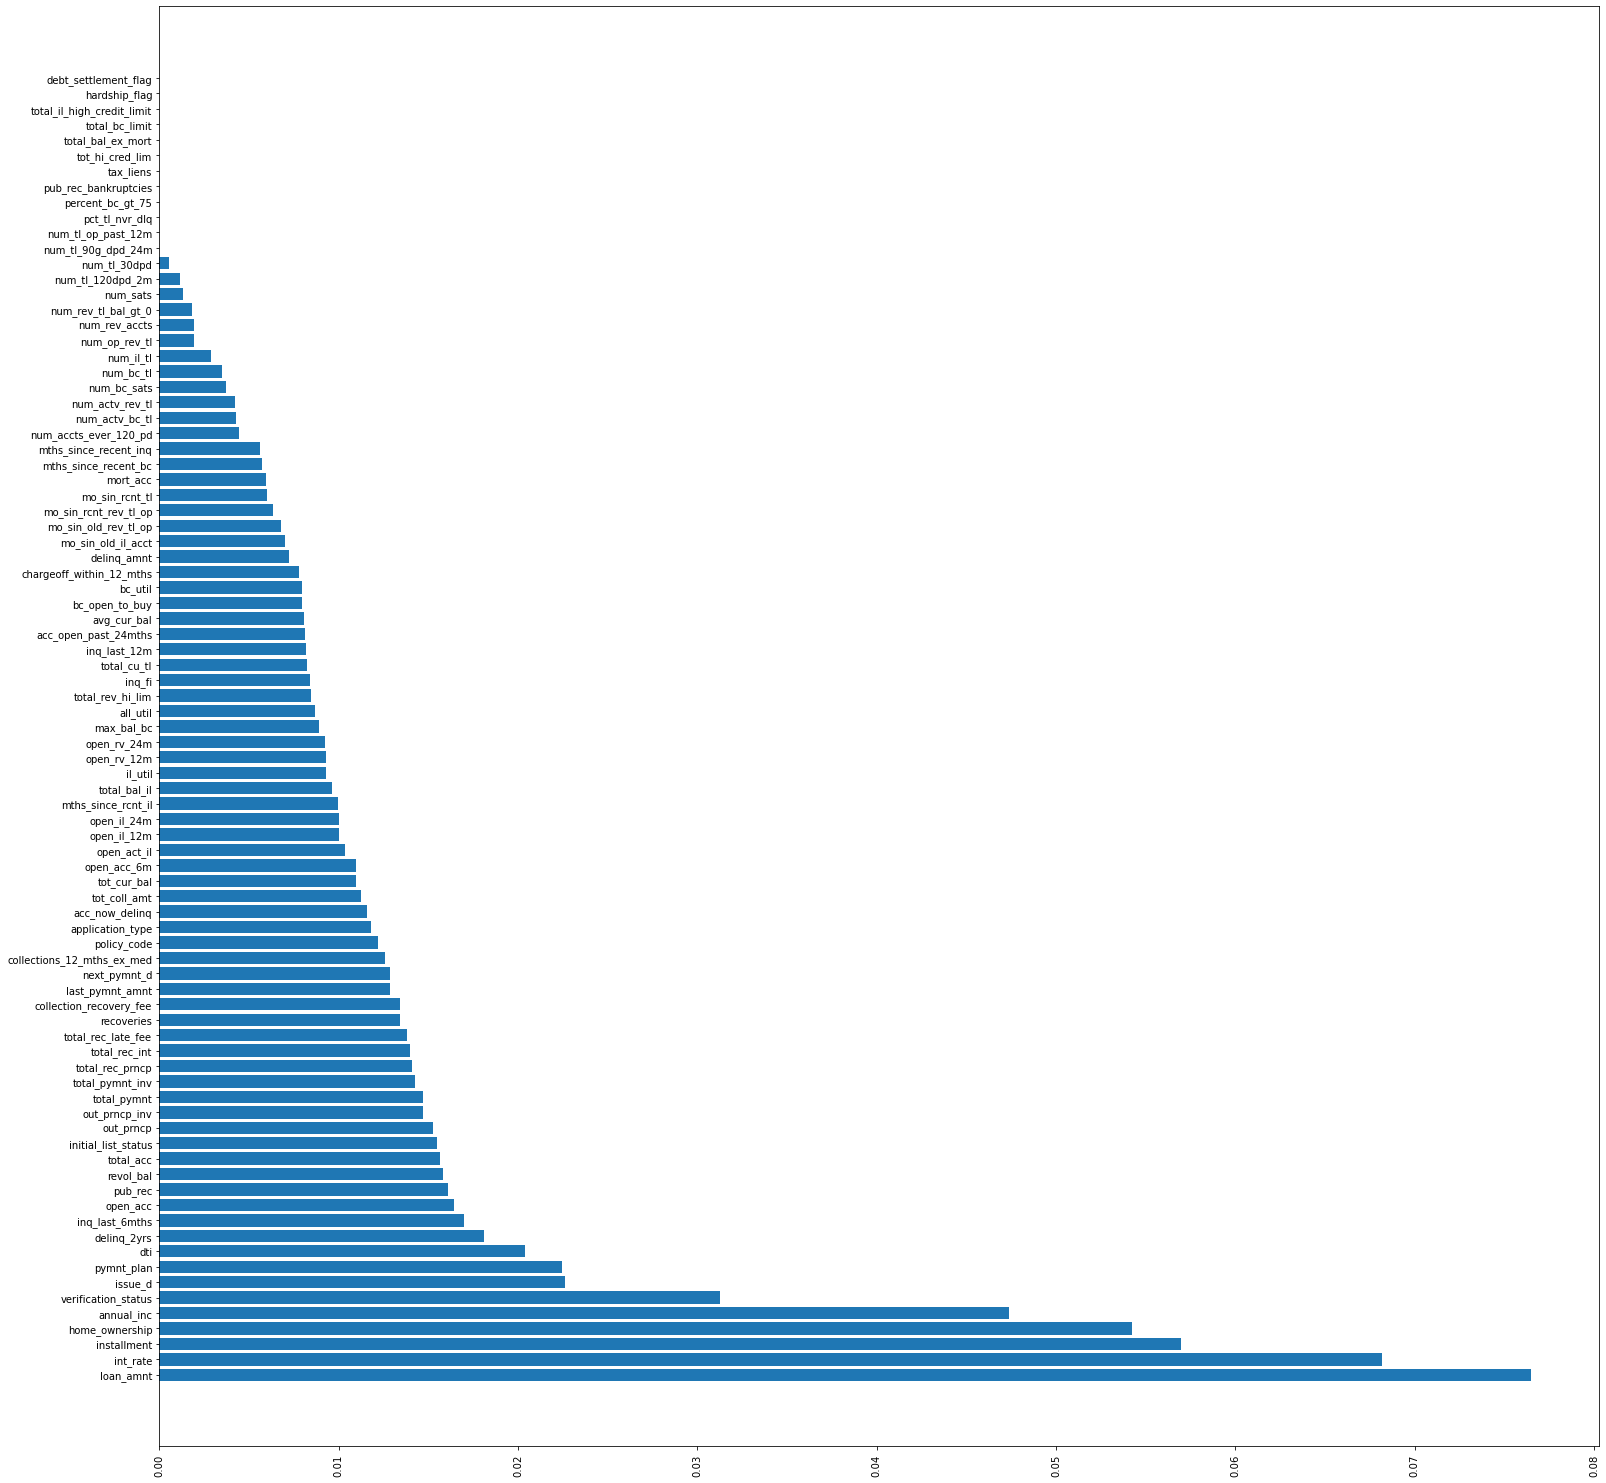

In [14]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,20))
ax = fig.add_axes([0,0,1,1])
ax.barh(X.columns,df3['Importance Score'])
plt.xticks(rotation='vertical')
# Tweak spacing to prevent clipping of tick-labels
plt.subplots_adjust(bottom=.5)
plt.show()

# EasyEnsembleClassifier

In [15]:
from imblearn.ensemble import EasyEnsembleClassifier

EECModel = EasyEnsembleClassifier(n_estimators=100, sampling_strategy='auto', random_state=1)

EECModel = EECModel.fit(X_train_scaled, y_train)

predict = EECModel.predict(X_test_scaled)
print(predict)

['low_risk' 'low_risk' 'low_risk' ... 'low_risk' 'low_risk' 'low_risk']


### Confusion Matrix

In [16]:
EECMatrix = confusion_matrix(y_test, predict)

EECMatrixDf = pd.DataFrame(
    EECMatrix, index=['Actually True', 'Actually False'], columns=['Predicted True', 'Predicted False']
)
EECMatrixDf

,Predicted True,Predicted False
Actually True,93,8
Actually False,983,16121


### Balanced Accuracy Score

In [17]:
# Displaying the balanced accuracy Score
EECAccScore  = balanced_accuracy_score(y_test,predict)
print(f"Accuracy Score: {EECAccScore}")

Accuracy Score: 0.9316600714093861


### Imbalanced Classification Report

In [18]:
# Displaying Classification Report
print(classification_report_imbalanced(y_test, predict))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.09      0.92      0.94      0.16      0.93      0.87       101
   low_risk       1.00      0.94      0.92      0.97      0.93      0.87     17104

avg / total       0.99      0.94      0.92      0.97      0.93      0.87     17205

